In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.models import resnet18
import torchvision.transforms as transforms
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import requests
import random
from typing import Tuple
from sklearn.metrics import roc_auc_score
import wandb
from tqdm import tqdm
from torch.optim import Adam, AdamW

In [3]:
!unzip  /content/drive/MyDrive/Data_model.zip

Archive:  /content/drive/MyDrive/Data_model.zip
   creating: Data_model/
  inflating: Data_model/01_MIA.pt    
  inflating: Data_model/priv_out.pt  
  inflating: Data_model/pub.pt       


In [4]:
!git clone https://github.com/yonsei-sslab/MIA.git


Cloning into 'MIA'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 213 (delta 119), reused 151 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (213/213), 2.46 MiB | 28.92 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

In [7]:
class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]

In [9]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])
data: MembershipDataset = torch.load("/content/Data_model/pub.pt", weights_only=False)
data.transform = transform

In [10]:
loaded = torch.load("/content/Data_model/priv_out.pt", weights_only=False)
data_priv = TaskDataset(transform=transform)
data_priv.ids = loaded.ids
data_priv.imgs = loaded.imgs
data_priv.labels = loaded.labels

In [16]:
loaded = torch.load("/content/Data_model/pub.pt", weights_only=False)
data_pub = TaskDataset(transform=transform)
data_pub.ids = loaded.ids
data_pub.imgs = loaded.imgs
data_pub.labels = loaded.labels

Generate train, eval, and test dataloaders for each shadow model using varying train sizes sampled from the public dataset.

In [17]:
num_total = 20000
num_shadow_models = 30
shadow_eval_size = 500
shadow_test_size = 1000

# Example: Try different sizes (e.g. linearly increasing)
train_sizes = np.linspace(300, 3000, num_shadow_models).astype(int)

list_train_loader = []
list_eval_loader = []
list_test_loader = []

for i in range(num_shadow_models):
    shadow_train_size = train_sizes[i]

    # Sample indices without replacement
    available_indices = np.arange(len(data_pub))
    train_indices = np.random.choice(available_indices, shadow_train_size, replace=False)
    remaining_indices = np.setdiff1d(available_indices, train_indices)

    eval_indices = np.random.choice(remaining_indices, shadow_eval_size, replace=False)
    remaining_indices = np.setdiff1d(remaining_indices, eval_indices)

    test_indices = np.random.choice(remaining_indices, shadow_train_size, replace=False)

    # Create subsets and loaders
    subset_train = Subset(data_pub, train_indices)
    subset_eval = Subset(data_pub, eval_indices)
    subset_test = Subset(data_pub, test_indices)

    subset_train_loader = DataLoader(subset_train, batch_size=64, shuffle=True, num_workers=2)
    subset_eval_loader = DataLoader(subset_eval, batch_size=64, shuffle=False, num_workers=2)
    subset_test_loader = DataLoader(subset_test, batch_size=64, shuffle=False, num_workers=2)

    list_train_loader.append(subset_train_loader)
    list_eval_loader.append(subset_eval_loader)
    list_test_loader.append(subset_test_loader)

    print(f"Shadow model {i+1}: Train size = {shadow_train_size}")


Shadow model 1: Train size = 300
Shadow model 2: Train size = 393
Shadow model 3: Train size = 486
Shadow model 4: Train size = 579
Shadow model 5: Train size = 672
Shadow model 6: Train size = 765
Shadow model 7: Train size = 858
Shadow model 8: Train size = 951
Shadow model 9: Train size = 1044
Shadow model 10: Train size = 1137
Shadow model 11: Train size = 1231
Shadow model 12: Train size = 1324
Shadow model 13: Train size = 1417
Shadow model 14: Train size = 1510
Shadow model 15: Train size = 1603
Shadow model 16: Train size = 1696
Shadow model 17: Train size = 1789
Shadow model 18: Train size = 1882
Shadow model 19: Train size = 1975
Shadow model 20: Train size = 2068
Shadow model 21: Train size = 2162
Shadow model 22: Train size = 2255
Shadow model 23: Train size = 2348
Shadow model 24: Train size = 2441
Shadow model 25: Train size = 2534
Shadow model 26: Train size = 2627
Shadow model 27: Train size = 2720
Shadow model 28: Train size = 2813
Shadow model 29: Train size = 2906
Sh

In [18]:
def get_model():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 44)
    return model.to(device)

In [19]:
from shadow.trainer import train
from utils.seed import seed_everything
from utils.load_config import load_config
from shadow.make_data import make_member_nonmember
import os

In [20]:
CFG = load_config("CFG")

In [21]:
# conduct training
if not os.path.exists(CFG.save_path):
    os.makedirs(CFG.save_path)

# seed for future replication
seed_everything(CFG.seed)

In [22]:
!wandb login --relogin

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [23]:
import shadow.trainer
import shadow.make_data
import importlib
importlib.reload(shadow.make_data)

<module 'shadow.make_data' from '/content/MIA/shadow/make_data.py'>

In [24]:
from shadow.make_data import make_member_nonmember

In [25]:
if not os.path.exists('./attack'):
    os.makedirs('./attack')

In [26]:
from collections import Counter

Generate attack dataset from shadow models by extracting features for member and non-member samples.



In [27]:
print("Label distribution:", Counter(data_pub.labels))
columns_attack_sdet = [f"all_{index}_prob" for index in range(44)] + [
    "loss", "margin", "entropy", "true_label"
]
df_attack_dset = pd.DataFrame({}, columns=columns_attack_sdet + ["is_member"])
print(df_attack_dset.head())

for shadow_number, shadow_loader in enumerate(tqdm(list_train_loader)):
    evalloader = list_eval_loader[shadow_number]
    testloader = list_test_loader[shadow_number]

    shadow_model = get_model()
    shadow_model = shadow_model.to(device)
    criterion = nn.CrossEntropyLoss()

    run_name = f"{shadow_model.__class__.__name__}_shadow_{shadow_number}"

    wandb.init(
        project="membership_inference_attack",
        group=f"{shadow_model.__class__.__name__}_shadow",
        name=run_name,
    )

    optimizer = AdamW(
        shadow_model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay
    )

    finetuned_model = train(
        CFG,
        shadow_model,
        shadow_loader,
        evalloader,
        optimizer,
        CFG.save_path,
        shadow_number,
        scheduler=None,
        criterion=criterion,
        device=device,
    )


    member_dset, non_member_dset = make_member_nonmember(
        finetuned_model, shadow_loader, testloader, criterion, device
    )

    df_member = pd.DataFrame(member_dset, columns=columns_attack_sdet)
    df_member["is_member"] = 1
    df_non_member = pd.DataFrame(non_member_dset, columns=columns_attack_sdet)
    df_non_member["is_member"] = 0

    df_attack_dset = pd.concat([df_attack_dset, df_member, df_non_member])
    df_attack_dset.to_csv(
        f"./attack/{shadow_model.__class__.__name__}_pretrained_{CFG.bool_pretrained}_num_shadow_{20}_CIFAR{44}.csv",
        index=False,
    )
    print("Attack models INPUT SIZE!!!! df_attack_dset:", df_attack_dset.shape)
    # Prevent OOM error by deleting finetuned model and datasets
    shadow_model.cpu()
    del shadow_model, optimizer, shadow_loader, evalloader, testloader
    torch.cuda.empty_cache()
    wandb.finish()

Label distribution: Counter({17: 3281, 41: 2817, 21: 2324, 36: 1984, 12: 951, 37: 776, 11: 737, 25: 681, 29: 635, 15: 634, 31: 613, 5: 553, 6: 483, 27: 467, 22: 454, 40: 450, 20: 448, 10: 301, 7: 211, 19: 130, 18: 121, 38: 120, 33: 97, 4: 87, 9: 55, 8: 53, 28: 51, 13: 46, 43: 45, 14: 40, 39: 39, 32: 35, 26: 34, 3: 33, 42: 33, 1: 31, 34: 28, 24: 28, 23: 27, 0: 26, 2: 21, 30: 9, 16: 7, 35: 4})
Empty DataFrame
Columns: [all_0_prob, all_1_prob, all_2_prob, all_3_prob, all_4_prob, all_5_prob, all_6_prob, all_7_prob, all_8_prob, all_9_prob, all_10_prob, all_11_prob, all_12_prob, all_13_prob, all_14_prob, all_15_prob, all_16_prob, all_17_prob, all_18_prob, all_19_prob, all_20_prob, all_21_prob, all_22_prob, all_23_prob, all_24_prob, all_25_prob, all_26_prob, all_27_prob, all_28_prob, all_29_prob, all_30_prob, all_31_prob, all_32_prob, all_33_prob, all_34_prob, all_35_prob, all_36_prob, all_37_prob, all_38_prob, all_39_prob, all_40_prob, all_41_prob, all_42_prob, all_43_prob, loss, margin, ent

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<IPython.core.display.Javascript object>

  0%|          | 0/30 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
from matplotlib import pyplot as plt

# get metric and train, test support
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# get classifier models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

CFG_ATTACK = load_config("CFG_ATTACK")

In [ ]:
CFG_ATTACK = load_config("CFG_ATTACK")

Extract full class probability vectors and compute per-sample loss, margin, and entropy for public data samples using the trained target model.

In [ ]:
model = get_model()
target_ckpt = torch.load("/content/New folder/01_MIA.pt", map_location=device)
model.load_state_dict(target_ckpt)
model.to(device).eval()

# === 1) Extract Full Probability Vectors on Public Data ===
pub_loader = DataLoader(data, batch_size=64, shuffle=False, pin_memory=True)

pub_feature_vectors, pub_member = [], []

with torch.no_grad():
    for ids, imgs, labels, flags in tqdm(pub_loader, desc="Extracting pub probabilities"):
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        probs  = F.softmax(logits, dim=1)
        # pub_probs.extend(probs.cpu().tolist())
        pub_member.extend(flags.tolist())
        for j in range(imgs.size(0)):
            sample_output = logits[j]
            sample_prob = probs[j]
            sample_label = labels[j]

            # Compute metrics
            loss = F.cross_entropy(sample_output.unsqueeze(0), sample_label.unsqueeze(0)).item()
            sorted_probs, _ = torch.sort(sample_prob, descending=True)
            margin = (sorted_probs[0] - sorted_probs[1]).item()
            entropy = -(sample_prob * torch.clamp(sample_prob, min=1e-12).log()).sum().item()

            # Feature vector = [class probs] + metrics
            feature_vector = list(sample_prob.cpu().numpy()) + [loss, margin, entropy, sample_label.item()]
            pub_feature_vectors.append(feature_vector)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Extracting pub probabilities: 100%|██████████| 313/313 [00:10<00:00, 31.04it/s]


Train a CatBoost attack model on combined shadow and public features, evaluate its performance, and save results.

Reading attack dataset: ./attack/ResNet_pretrained_False_num_shadow_20_CIFAR44.csv
<bound method NDFrame.head of        all_0_prob    all_1_prob    all_2_prob    all_3_prob  all_4_prob  \
0        0.004518  6.965475e-05  3.455520e-05  2.684348e-04    0.004159   
1        0.013667  7.221971e-05  3.272722e-05  2.644803e-04    0.006073   
2        0.004427  8.756637e-05  1.058977e-04  2.091568e-04    0.009051   
3        0.000005  6.853465e-07  2.994431e-07  3.831628e-07    0.000005   
4        0.000232  3.172704e-05  2.544559e-05  5.594483e-05    0.000467   
...           ...           ...           ...           ...         ...   
98967    0.000069  1.156014e-04  7.870839e-06  7.362327e-04    0.000100   
98968    0.000055  3.841132e-05  1.269133e-06  1.617404e-05    0.000002   
98969    0.000010  2.663476e-05  1.047225e-06  2.521294e-04    0.000035   
98970    0.000010  8.659206e-05  7.479552e-07  2.240598e-04    0.000100   
98971    0.000315  2.932316e-04  1.417304e-05  6.573848e-04   

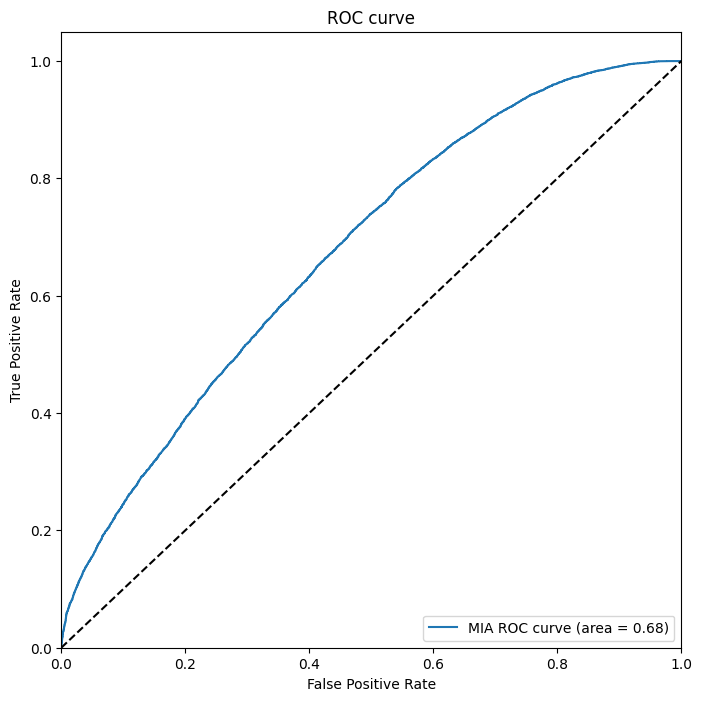

<Figure size 640x480 with 0 Axes>

In [ ]:
df_shadow = pd.read_csv(CFG_ATTACK.attack_dset_path)
print("Reading attack dataset:", CFG_ATTACK.attack_dset_path)
print(df_shadow.head)
print("data shape:", df_shadow.shape)

# train attack model
y = df_shadow["is_member"]
X = df_shadow.drop(["is_member"], axis=1)

df_pub = pd.DataFrame(pub_feature_vectors, columns=X.columns)

# Concatenate X with df_pub
X_combined = pd.concat([X, df_pub], ignore_index=True)

# Concatenate y with y_pub
y_combined = pd.concat([y, pd.Series(pub_member, name="is_member")], ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=CFG_ATTACK.test_size, random_state=CFG.seed
)


model = CatBoostClassifier(
    iterations=CFG_ATTACK.train_epoch,
    depth=2,
    learning_rate=CFG_ATTACK.learning_rate,
    loss_function="Logloss",
    verbose=True,
)

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test, model.predict(X_test), average="binary"
)
print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1_score:", f1_score)

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
print("mean fpr:", np.mean(fpr))
print("mean tpr:", np.mean(tpr))

tpr_005 = tpr[(fpr >= 0.05).argmax()]
print(f"TPR@FPR=0.05 = {tpr_005:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="MIA ROC curve (area = %0.2f)" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()
plt.savefig(CFG_ATTACK.roc_curve_path)


save_path = f"./attack/{model.__class__.__name__}_{accuracy}"
model.save_model(save_path)

Extracts softmax probabilities, loss, margin, entropy, and true label from the target model for each private data sample to create feature vectors for membership inference.

In [ ]:
target_model = get_model()
target_ckpt = torch.load("/content/Data_model/01_MIA.pt", map_location=device)
target_model.load_state_dict(target_ckpt)
target_model.eval()

privateloader = DataLoader(data_priv, batch_size=64, shuffle=False, num_workers=2)

# features = []
target_feature_vectors = []
# finetuned_model.eval()
with torch.no_grad():
    for i, (ids, images, labels) in enumerate(tqdm(privateloader)):
        images = images.to(device)
        labels = labels.to(device)

        # compute output
        output = target_model(images)
        prob = F.softmax(output, dim=1)  # softmax logits

        for j in range(images.size(0)):
            sample_output = output[j]
            sample_prob = prob[j]
            sample_label = labels[j]

            loss = F.cross_entropy(sample_output.unsqueeze(0), sample_label.unsqueeze(0)).item()
            sorted_probs, _ = torch.sort(sample_prob, descending=True)
            margin = (sorted_probs[0] - sorted_probs[1]).item()
            entropy = -(sample_prob * torch.clamp(sample_prob, min=1e-12).log()).sum().item()

            # Feature vector: all class probs + loss + margin + entropy + true label
            feature_vector = list(sample_prob.cpu().numpy()) + [loss, margin, entropy, sample_label.item()]
            target_feature_vectors.append(feature_vector)


columns_attack_features = [f"all_{i}_prob" for i in range(44)] + ["loss", "margin", "entropy", "true_label"]

df_target = pd.DataFrame(target_feature_vectors, columns=columns_attack_features)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 313/313 [00:11<00:00, 26.86it/s]


In [ ]:
df_target.head()

,all_0_prob,all_1_prob,all_2_prob,all_3_prob,all_4_prob,all_5_prob,all_6_prob,all_7_prob,all_8_prob,all_9_prob,...,all_38_prob,all_39_prob,all_40_prob,all_41_prob,all_42_prob,all_43_prob,loss,margin,entropy,true_label
0,3.261113e-21,1.222014e-16,1.285417e-15,1.624586e-21,2.548627e-22,4.269057e-15,6.993806e-18,8.911915e-23,9.542625e-21,1.365819e-19,...,1.675564e-18,5.368840e-20,1.465947e-08,7.424654e-16,7.116951e-21,1.094312e-22,0.000000e+00,1.000000,9.006229e-07,11
1,9.795522e-22,1.788099e-16,1.219056e-17,1.063301e-22,1.108040e-21,1.741644e-13,4.011657e-18,4.589963e-23,1.689308e-22,1.273456e-20,...,7.153509e-20,3.658574e-22,1.035718e-07,1.749470e-18,5.822015e-22,6.040347e-23,1.192093e-07,1.000000,1.794379e-06,11
2,6.481055e-10,6.672424e-11,4.942376e-12,2.966136e-12,1.893922e-16,4.839733e-12,1.044393e-07,5.782660e-14,1.166469e-12,1.592655e-14,...,1.496985e-12,1.496483e-11,8.792107e-11,2.497999e-12,1.205682e-12,1.883626e-12,1.350179e+01,0.998658,5.688133e-03,25
3,2.108354e-36,1.008609e-29,1.880650e-25,4.643068e-34,2.068530e-35,1.616960e-25,6.000442e-35,5.059211e-33,1.018005e-30,5.387592e-35,...,2.049799e-25,3.784844e-31,9.817873e-26,2.168864e-31,1.482684e-27,2.084331e-29,0.000000e+00,1.000000,2.019576e-12,31
4,1.056981e-09,3.374493e-15,3.715175e-14,5.897871e-14,3.859257e-19,5.511858e-10,8.877949e-11,1.884362e-13,9.442468e-16,8.045709e-13,...,5.580500e-14,5.212443e-14,1.229889e-12,3.494804e-06,2.014655e-16,1.545216e-13,2.069952e-03,0.995868,1.487354e-02,36


In [ ]:
attack_model = CatBoostClassifier()
attack_model.load_model(CFG_ATTACK.attack_model_path)

In [ ]:
membership_scores = attack_model.predict_proba(df_target)[:, 1]

In [ ]:
len(membership_scores)

20000

In [ ]:
count_less_than_0_5 = sum(1 for score in membership_scores if score < 0.5)
print(f"Number of scores less than 0.5: {count_less_than_0_5}")


Number of scores less than 0.5: 6090


In [ ]:
df = pd.DataFrame(
    {
        "ids": data_priv.ids,
        "score": membership_scores,
    }
)

# Save to CSV (no index)
df.to_csv("mia_submission.csv", index=False)



In [ ]:
# Submit to the API
API_ENDPOINT = "http://34.122.51.94:9090/mia"
TOKEN = "61729223"  # Your provided token

with open("mia_submission.csv", "rb") as f:
    response = requests.post(
        API_ENDPOINT,
        files={"file": f},
        headers={"token": TOKEN}
    )

print("API Response:", response.json())

API Response: {'TPR@FPR=0.05': 0.144, 'AUC': 0.6550277222222222}


In [ ]:
print("LOL")

LOL
